### Model Selection

We want to model the chemical yield in a chemical manufacturing process. For this purpose we have the following features to use. 
* $x_1: \text{amount of catalyst}$
* $x_2: \text{preprocessing 2 or not}$
* $x_3: \text{preprocessing 3 or not}$
* $x_4: \text{humidity}$
* $x_5: \text{oxygen in the surrounding environment}$
* $x_6: \text{time for the process}$
* $x_7: \text{time squared for the process}$
* $x_8: \text{temperature}$

In this notebook we want to employ the forward model selection algorithm to find the best model and the most appropriate features.

First, we import and examine the data.

In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

# Plotting configuration
%config InlineBackend.figure_format = 'retina'
plt.style.use(['science', 'notebook', 'grid'])

In [2]:
df = pd.read_csv('data/model_selection.csv')
df.head()

,y,x1,x2,x3,x4,x5,x6,x7,x8
0,91.374796,0.819871,0,0,23.519703,0.236962,4.0,16.00,483.455385
1,138.115672,5.430172,0,0,21.768835,0.231744,3.9,15.21,442.515460
2,117.091176,3.221197,1,0,21.903063,0.281032,3.8,14.44,464.683876
3,106.688269,2.443834,1,0,21.113056,0.210262,3.7,13.69,450.844253
4,78.589962,0.223265,0,1,16.282516,0.221276,3.6,12.96,337.399967


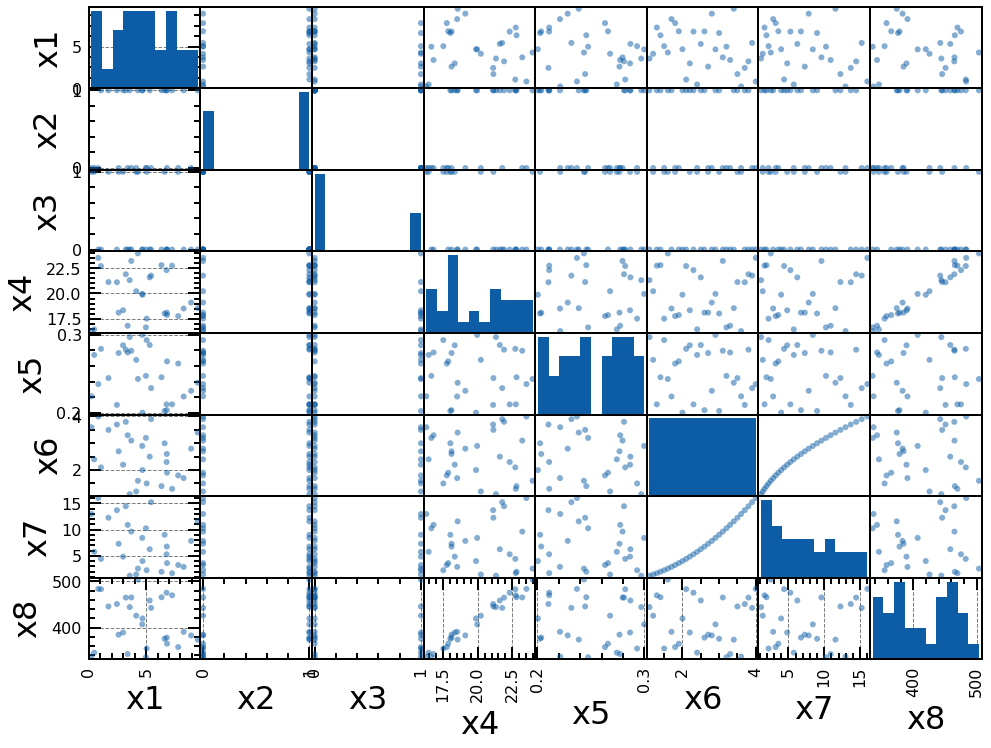

In [15]:
# Scatter matrix.
pd.plotting.scatter_matrix(df.iloc[:, 1:], alpha=0.5) 
plt.show()

### Comparison/Benchmark Model

To compare the forward and backward selection models we have a benchmark model which includes all features. The model is shown below:

$$
Y_i = \sum_{i=0}^8\beta_i x^i + \varepsilon_i 
$$

For this model we can solve the normal equations again, and find the explanatory power $R_{\text{adj}}^2$ of the model.

In [238]:
N_OBSERVATIONS = len(df)
DATA_DF = df

class RegressionModel:
    def __init__(self, features: list, data: pd.DataFrame = DATA_DF):
        self.features = features
        self.nr_featuers = len(self.features)
        self.data = data
        self.n_observations = len(self.data)
        self.design_matrix = self.create_design_matrix()
        self.y_values = np.array(self.data['y'])
        self.solution = self.solve_normal_equations()
        self.sse_val = self.sse()
        self.adj2_val = self.adj_r2()
        self.sigma2_est = self.sse_val / (self.n_observations - self.nr_featuers - 1)
        self.beta_cov = self.sigma2_est * np.linalg.inv(self.design_matrix.T @ self.design_matrix)
        
    def create_design_matrix(self) -> np.array:
        design_matrix = []
        ones = np.ones(self.n_observations)
        design_matrix.append(ones)
        for feature in self.features:
            design_matrix.append(np.array(self.data[feature]))
        return np.stack(design_matrix).T

    def solve_normal_equations(self) -> np.array:
        return (np.linalg.inv(self.design_matrix.T @ self.design_matrix) 
                @ self.design_matrix.T @ self.y_values)

    def sse(self):
        y_hat = self.design_matrix @ self.solution

        return (self.y_values - y_hat).T @ (self.y_values - y_hat) 

    def sst(self):
        mean = np.mean(self.y_values)
        return (self.y_values - mean).T @ (self.y_values - mean)

    def adj_r2(self):
        return (1 - (self.sse() / (self.n_observations - self.nr_featuers - 1) ) 
                / (self.sst() / (self.n_observations - 1)))


In [281]:
# Creating benchmark model.
benchmark_features = df.columns[1:]
benchmark_model = RegressionModel(benchmark_features)
print('Benchmark model Adj R2:', benchmark_model.adj2_val)
print('Benchmark model SSE value:', benchmark_model.sse_val)
benchmark_model.solution

Benchmark model Adj R2: 0.9969122086075268
Benchmark model SSE value: 58.58623059804797


array([-5.19980752, 10.25063316,  1.75272739,  0.50546691, -7.02832998,
       15.44683607, 11.37729485,  3.79193724,  0.29972183])

### Forward Model Selection

The forward selection algorithm works by iteratively building a model beginning with an empty model. The steps of adding an initial feature, and introducing more features (deemed to be statistically significant) in a systematic way is described below.

1. Pick the variable with the highest correlation to the response variable $y$ and create a regression model
2. Run $(n-1)$ regressions; adding one new feature of all. Pick the feature that minimizes SSE.
3. Run a hypothesis test on whether or not $\beta_{\text{candidate}} = 0$ 
4. Stop when 3. cannot reject the null hypothesis

In [317]:
import copy

from scipy.stats import t

# Significance level.
ALPHA = 0.05

# Regression features.
current_features = set()
features = set(df.columns[1:])

# Initial variable.
corr = df.corr().iloc[0][1:]
init_feature = corr.abs().idxmax()
current_features.add(init_feature)
init_model = RegressionModel(current_features)

# Forward selection.
for i in range(0, len(features) - 1):
    best_candidate_feture = None
    best_candidate_sse = np.inf
    best_candidate_sol_index = None

    # Note to self, don't use sets.
    for feature in features.difference(current_features):
        temp_features = copy.deepcopy(current_features)
        temp_features.add(feature)
        temp_model = RegressionModel(temp_features)
        if temp_model.sse_val < best_candidate_sse:
            best_candidate_sse = temp_model.sse_val
            best_candidate_feture = feature

    best_candidate_model = copy.deepcopy(current_features)
    best_candidate_model.add(best_candidate_feture)
    best_candidate_index = list(best_candidate_model).index(best_candidate_feture)
    best_candidate_regression = RegressionModel(best_candidate_model)
    
    # 1 - ALPHA % hypothesis test for candidate coefficient.
    t_stat = (best_candidate_regression.solution[best_candidate_index] 
              / np.sqrt(temp_model.beta_cov[best_candidate_index][best_candidate_index]))
    if abs(t_stat) > t.ppf(1-ALPHA/2, temp_model.n_observations - temp_model.nr_featuers - 1):
        current_features.add(best_candidate_feture)

forward_model = RegressionModel(current_features)
print('Forward model adj_r2:', full_model.adj2_val)

Forward model adj_r2: 0.9934381489724703


### Forward Model versus Benchmark Model

After having ascertained a forward model, we can now test it against the benchmark model. We want to ask whether or not the additional features of the benchmark model contributes to reducing SSE in a statistically significant way.

This can be done with the following hypothesis test:

$$
\mathbf{H}_0: \beta_{n+1} = \ldots = \beta_{n+p} = 0
$$
$$
\mathbf{H}_a: \text{At least one $\beta_{n+i} \neq 0$}
$$

Which is used for the models:

$$
Y^{\text{total}}_i = \sum_j \beta_j x_j + \varepsilon_i
$$
$$
Y^{\text{forward}}_i = \sum_k \beta_k x_k + \varepsilon_i
$$

With the following test statistic:

$$
W = \frac{(\text{SSE}_2-\text{SSE}_1) / p}{\text{SSE}_1 / (n - k - p - 1)} \sim \textbf{F}(p,~n-k-p-1)
$$

Where large values of $W$ gives evidence against the null hypotheis. The rejection region for the F-test is simply found as $C = (F_{1-\alpha}(p,n-k-p-1), \infty)$.

In [324]:
from scipy.stats import f

# SSE for forward model and benchmark model
SSE_2 = forward_model.sse_val
SSE_1 = benchmark_model.sse_val

# Degrees of freedom 
extra_n_features = len(current_features)
total_n_featuers = benchmark_model.nr_featuers
n_observations = benchmark_model.n_observations

# Test statistic
W = ((SSE_2 - SSE_1) / extra_n_features) / (SSE_1 / (n_observations - extra_n_features - total_n_featuers - 1))

# Rejection region
F = f.ppf(0.95, extra_n_features, n_observations - extra_n_features - total_n_featuers -1)

print('Rejection region:', F)
print('Test statistic:', W)

Rejection region: 2.852409165081986
Test statistic: 4.571777158736367
